In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# We're using scikit so load in all the required dependencies
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [2]:
# Load in the .csv files
data_dir = "input/gmsc"
train = pd.read_csv(f"{data_dir}/cs-training.csv")
test = pd.read_csv(f"{data_dir}/cs-test.csv")
submission = pd.read_csv(f"{data_dir}/sampleEntry.csv")

In [3]:
# Shows the shape and info of the dataframe
print("shape of dataframe is : ", train.shape)
train.info()

shape of dataframe is :  (150000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNo

In [4]:
# Rename the first column "Unnamed" to be "ID"
data = [train, test]
for df in data:
    df.rename(columns = {'Unnamed: 0': 'ID'}, inplace=True)

In [5]:
# Replace the null values to round out the training dataframe
train['MonthlyIncome'].fillna(train['MonthlyIncome'].mean(), inplace=True)
train['NumberOfDependents'].fillna(train['NumberOfDependents'].mode()[0], inplace=True)

train.isnull().sum()

ID                                      0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [6]:
# Replace the null values to round out the test dataframe
test['MonthlyIncome'].fillna(test['MonthlyIncome'].mean(), inplace=True)
test['NumberOfDependents'].fillna(test['NumberOfDependents'].mode()[0], inplace=True)

test.isnull().sum()

ID                                           0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                                0
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                           0
dtype: int64

In [7]:
# Drop the columns we don't need from our features and set our label
X = train.drop(['ID', 'SeriousDlqin2yrs'], axis=1)
y = train['SeriousDlqin2yrs']

X_test = test.drop(['ID', 'SeriousDlqin2yrs'], axis=1)
y_test = test['SeriousDlqin2yrs']

In [8]:
# Transform our numerical columns for training and test data
num_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
scale = StandardScaler()
scale.fit(X[num_columns])
X[num_columns] = scale.transform(X[num_columns]).copy()
X_test[num_columns] = scale.transform((X_test[num_columns])).copy()

In [9]:
# Normalise our labels
y.value_counts(normalize=True)
y_test.value_counts(normalize=True)

Series([], Name: proportion, dtype: float64)

In [10]:
# Define our decision tree classifier. Using 10 nodes as it predicts well without overfitting
model = DecisionTreeClassifier(max_leaf_nodes=10, random_state=42)
model.fit(X, y)

DecisionTreeClassifier(max_leaf_nodes=10, random_state=42)

In [11]:
# Define Stratified sampling for out data
cv = StratifiedKFold(n_splits= 10, shuffle= True, random_state=13)
roc_auc_scores = cross_val_score(model, X, y, scoring= 'roc_auc', cv=cv, n_jobs = -1)
roc_auc_scores.mean()

0.8199865584650153

In [12]:
# Obtain our predictions
y_pred = model.predict(X)
y_pred_proba = model.predict_proba(X)[:,1]
y_test_pred_proba = model.predict_proba(X_test)[:,1]

In [13]:
# roc_aoc_score for our predictions
roc_auc_score(y, y_pred_proba)

0.8201238245547929

In [14]:
# Plot the roc curve
def plot_roc(y, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.plot(fpr, fpr, linestyle = '--', color = 'k')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')

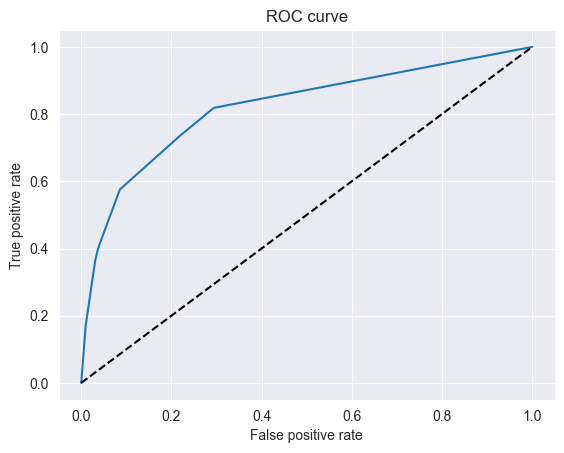

In [15]:
plot_roc(y, y_pred_proba)

In [16]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97    139974
           1       0.55      0.17      0.26     10026

    accuracy                           0.94    150000
   macro avg       0.75      0.58      0.61    150000
weighted avg       0.92      0.94      0.92    150000


[Text(0.6029411764705882, 0.9, 'NumberOfTimes90DaysLate <= 0.056\ngini = 0.125\nsamples = 150000\nvalue = [139974, 10026]\nclass = y[0]'),
 Text(0.3235294117647059, 0.7, 'RevolvingUtilizationOfUnsecuredLines <= -0.022\ngini = 0.088\nsamples = 141662\nvalue = [135108, 6554]\nclass = y[0]'),
 Text(0.11764705882352941, 0.5, 'NumberOfTime30-59DaysPastDueNotWorse <= 0.019\ngini = 0.05\nsamples = 112818\nvalue = [109944, 2874]\nclass = y[0]'),
 Text(0.058823529411764705, 0.3, 'gini = 0.035\nsamples = 100612\nvalue = [98794.0, 1818.0]\nclass = y[0]'),
 Text(0.17647058823529413, 0.3, 'NumberOfTime60-89DaysPastDueNotWorse <= 0.062\ngini = 0.158\nsamples = 12206\nvalue = [11150, 1056]\nclass = y[0]'),
 Text(0.11764705882352941, 0.1, 'gini = 0.136\nsamples = 11162\nvalue = [10343, 819]\nclass = y[0]'),
 Text(0.23529411764705882, 0.1, 'gini = 0.351\nsamples = 1044\nvalue = [807, 237]\nclass = y[0]'),
 Text(0.5294117647058824, 0.5, 'NumberOfTime30-59DaysPastDueNotWorse <= 0.019\ngini = 0.223\nsampl

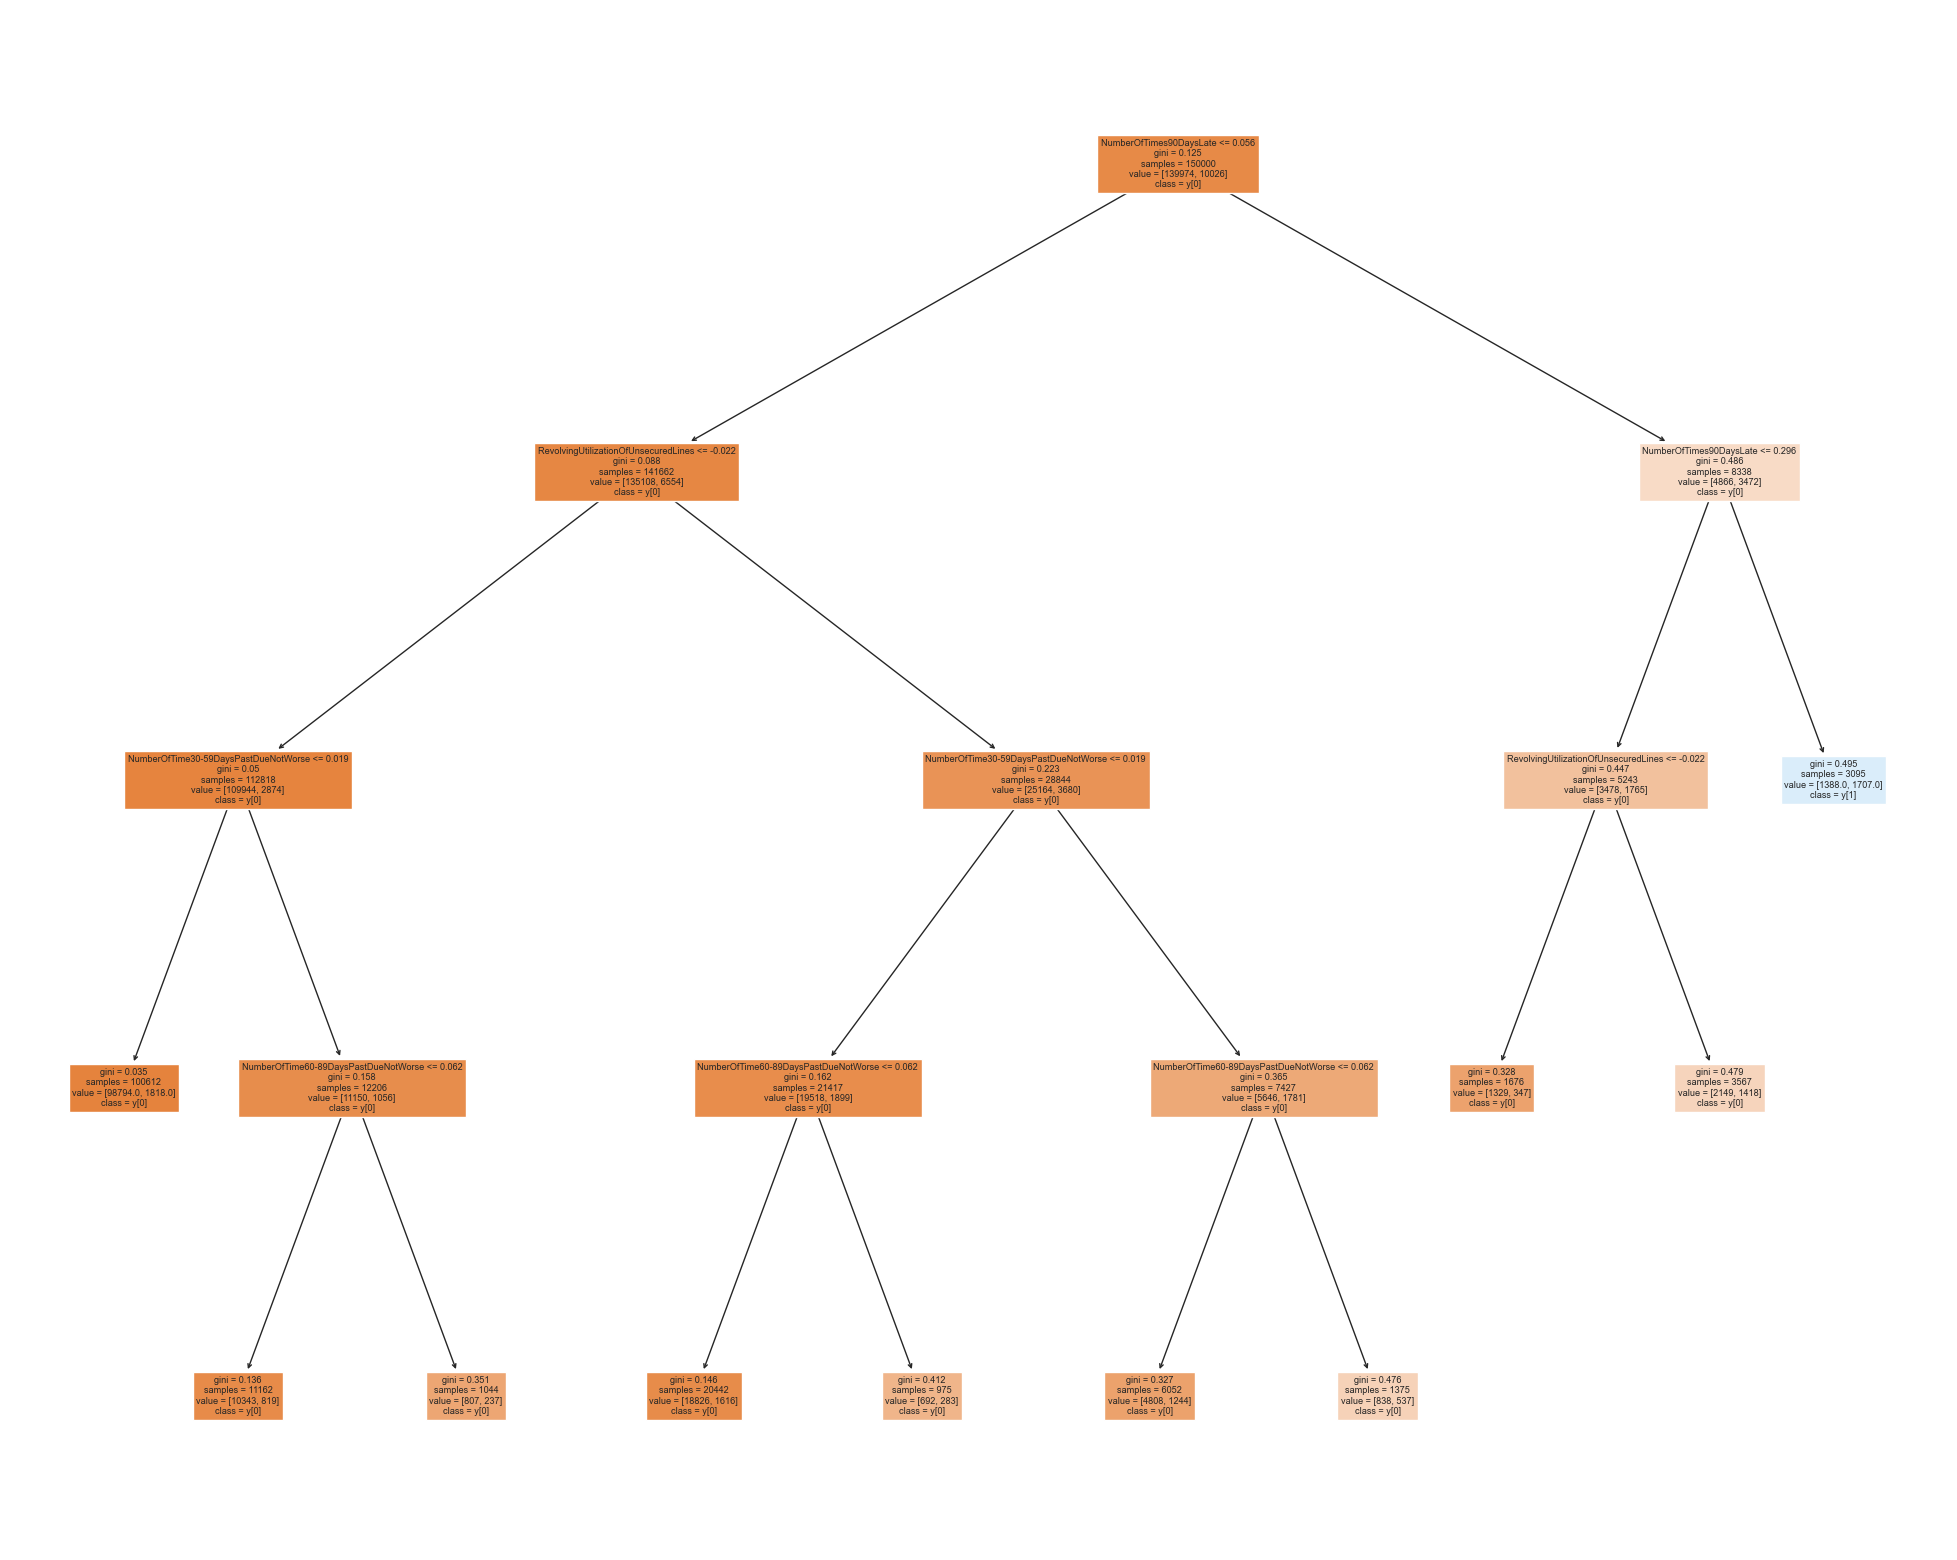

In [17]:
# Display our decision tree
from sklearn import tree
fig = plt.figure(figsize=(25,20))
# tree.plot_tree(model)

tree.plot_tree(model,
    feature_names=X.columns,
    class_names=True,
    filled=True)


In [18]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F

# Assuming 'train' is your DataFrame and 'y' is your labels Series

# Convert DataFrame to numpy arrays
X_np = train.drop(['ID', 'SeriousDlqin2yrs'], axis=1).values
y_np = train['SeriousDlqin2yrs'].values

# Standardize features
scaler = StandardScaler()
X_np_scaled = scaler.fit_transform(X_np)

# Splitting the dataset for demonstration (you can skip this if you have separate train/test sets)
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_np_scaled, y_np, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float)
y_train = torch.tensor(y_train_np[:, None], dtype=torch.float)  # Reshape for BCELoss
X_test = torch.tensor(X_test_np, dtype=torch.float)
y_test = torch.tensor(y_test_np[:, None], dtype=torch.float)  # Reshape for BCELoss

Epoch 1, Loss: 0.7769544124603271
Epoch 2, Loss: 0.7632261514663696
Epoch 3, Loss: 0.7500746250152588
Epoch 4, Loss: 0.7374529838562012
Epoch 5, Loss: 0.7252876162528992
Epoch 6, Loss: 0.7135221362113953
Epoch 7, Loss: 0.702092170715332
Epoch 8, Loss: 0.6909388303756714
Epoch 9, Loss: 0.680014431476593
Epoch 10, Loss: 0.6692728400230408
Epoch 11, Loss: 0.6586709022521973
Epoch 12, Loss: 0.648165762424469
Epoch 13, Loss: 0.6377217173576355
Epoch 14, Loss: 0.6273033618927002
Epoch 15, Loss: 0.6168872117996216
Epoch 16, Loss: 0.6064453125
Epoch 17, Loss: 0.5959466099739075
Epoch 18, Loss: 0.5853782296180725
Epoch 19, Loss: 0.574736475944519
Epoch 20, Loss: 0.5640162825584412
Epoch 21, Loss: 0.5532123446464539
Epoch 22, Loss: 0.5423275232315063
Epoch 23, Loss: 0.5313701033592224
Epoch 24, Loss: 0.5203586220741272
Epoch 25, Loss: 0.5093346238136292
Epoch 26, Loss: 0.4983171820640564
Epoch 27, Loss: 0.48732662200927734
Epoch 28, Loss: 0.47638940811157227
Epoch 29, Loss: 0.46553874015808105
E

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees in the forest

# Train the Random Forest model on the training data
rf_model.fit(X_train_np, y_train_np)

# Predict on the test data
y_pred_rf = rf_model.predict(X_test_np)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test_np, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")


Random Forest Accuracy: 0.9366


In [22]:
def calculate_tree_coverage(random_forest, X_test):
    # Each tree in the forest makes a prediction for each test instance
    tree_predictions = np.array([tree.predict(X_test) for tree in random_forest.estimators_])

    # Determine the number of unique prediction patterns across trees
    unique_patterns = np.unique(tree_predictions, axis=0)

    # Tree coverage could be defined as the proportion of unique prediction patterns
    tree_coverage = len(unique_patterns) / len(random_forest.estimators_)
    return tree_coverage

# Calculate tree coverage for the Random Forest model
tree_coverage = calculate_tree_coverage(rf_model, X_test_np)
print(f"Tree Coverage: {tree_coverage:.4f}")


Tree Coverage: 1.0000


In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the Gradient Boosting model on the training data
gb_model.fit(X_train_np, y_train_np.ravel())  # .ravel() to convert y_train_np to the correct shape

# Predict on the test data
y_pred_gb = gb_model.predict(X_test_np)

# Calculate accuracy
accuracy_gb = accuracy_score(y_test_np, y_pred_gb)
print(f"Gradient Boosting Classifier Accuracy: {accuracy_gb:.4f}")


Gradient Boosting Classifier Accuracy: 0.9387


In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Initialize the MLPClassifier
# This example creates a neural network with two hidden layers, each with 100 neurons, and uses the ReLU activation function.
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', random_state=42)

# Train the MLPClassifier on the training data
mlp_model.fit(X_train_np, y_train_np)

# Predict on the test data
y_pred_mlp = mlp_model.predict(X_test_np)

# Calculate accuracy
accuracy_mlp = accuracy_score(y_test_np, y_pred_mlp)
print(f"MLPClassifier Accuracy: {accuracy_mlp:.4f}")

import numpy as np

def relu_activation(x):
    return np.maximum(0, x)

def compute_activations(X, model):
    # Start with the input layer as the initial activation (i.e., the input features)
    A = X
    activations = []

    # Iterate over the layers, applying weights and biases
    for i in range(len(model.coefs_)):
        W = model.coefs_[i]
        b = model.intercepts_[i]

        # Compute the activation for the current layer
        Z = np.dot(A, W) + b
        A = relu_activation(Z)  # Apply ReLU activation function

        # Store the activation of the current layer
        activations.append(A)

    return activations

def calculate_neuron_coverage(activations, threshold=0.5):
    activated_neurons = sum((activation > threshold).sum() for activation in activations)
    total_neurons = sum(activation.size for activation in activations)
    neuron_coverage = activated_neurons / total_neurons * 100
    return neuron_coverage

# Compute the activations for the test set
activations = compute_activations(X_test_np, mlp_model)

# Calculate neuron coverage
neuron_coverage = calculate_neuron_coverage(activations, threshold=0.0)
print(f"Neuron Coverage: {neuron_coverage:.2f}%")


MLPClassifier Accuracy: 0.9363
Neuron Coverage: 41.35%


/Users/jasperbruin/anaconda3/envs/lab_2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [28]:
def compute_binary_activations(X, model, threshold=0.5):
    activations = compute_activations(X, model)
    binary_activations = []
    for activation in activations:
        binary_activation = (activation > threshold).astype(int)
        binary_activations.append(binary_activation)
    return binary_activations

def calculate_path_coverage(X, model, threshold=0.5):
    binary_activations = compute_binary_activations(X, model, threshold)
    pattern_set = set()
    for i in range(len(X)):
        pattern = ''.join(str(binary_activation[i]) for binary_activation in binary_activations)
        pattern_set.add(pattern)
    path_coverage = len(pattern_set)
    return path_coverage

# Calculate path coverage
path_coverage = calculate_path_coverage(X_test_np, mlp_model, threshold=0.0)
print(f"Path Coverage: {path_coverage}")

# Assuming `activations` is a list of activation arrays from your model
total_activation_bits = sum(activation.size for activation in activations)
print(f"Total Paths: 2^{total_activation_bits}")



Path Coverage: 25364
Total Paths: 2^3870000
